#  Sentiment Analysis with TensorFlow 2

Amazon SageMaker provides both (1) built-in algorithms and (2) an easy path to train your own custom models.  Although the built-in algorithms cover many domains (computer vision, natural language processing etc.) and are easy to use (just provide your data), sometimes training a custom model is the preferred approach.  This notebook will focus on training a custom model using TensorFlow 2.  

Sentiment analysis is a very common text analytics task that determines whether a text sample is positive or negative about its subject.  There are several different algorithms for performing this task, including older statistical algorithms and newer deep learning algorithms.  With respect to deep learning, a 1D Convolutional Neural Net (CNN) is sometimes used for this purpose.  In this notebook we'll use a CNN built with TensorFlow 2 to perform sentiment analysis in Amazon SageMaker on the IMDb dataset, which consists of movie reviews labeled as having positive or negative sentiment. Several aspects of Amazon SageMaker will be demonstrated:

- How to use a SageMaker prebuilt TensorFlow 2 container with a custom model training script similar to one you would use outside SageMaker. This feature is known as Script Mode.  
- Hosted training: for full scale training on a complete dataset on a separate, larger and more powerful SageMaker-managed GPU instance.  
- Distributed training:  using multiple GPUs to speed up training.  
- Batch Transform: for offline, asynchronous predictions on large batches of data. 
- Instance type choices:  many different kinds of CPU and GPU instances are available in SageMaker, and are applicable to different use cases.

#  Prepare the dataset

We'll begin by loading the reviews dataset, and padding the reviews so all reviews have the same length.  Each review is represented as an array of numbers, where each number represents an indexed word.  We'll also pad shorter reviews to match a maximum specified length.

In [2]:
pip install tensorflow

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 458.3 MB 7.4 kB/s  eta 0:00:011
     |████████████████████████████████| 65 kB 442 kB/s  eta 0:00:01
     |████████████████████████████████| 3.9 MB 70.7 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 45.4 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 99.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 31.4 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 60.6 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 176 kB/s  eta 0:00:01
     |████████████████████████████████

In [3]:
%matplotlib inline

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import numpy as np
import os

from tensorflow.keras.preprocessing import sequence
from tensorflow.python.keras.datasets import imdb

max_features = 20000
maxlen = 400

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

#This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). 
#num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
x_train shape: (25000, 400)
x_test shape: (25000, 400)


In [32]:
#first row
#x_train[0]
#first two rows
x_train[:5]

#np.savetxt('test.csv', x_train, delimiter=',')

array([[   0,    0,    0, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       [ 263, 2504,  182, ...,   21,   64, 2574],
       [   0,    0,    0, ...,    7,   61,  113]], dtype=int32)

Next, we'll save the padded data to files, locally for now, and later to Amazon S3.

In [4]:
data_dir = os.path.join(os.getcwd(), 'data')
os.makedirs(data_dir, exist_ok=True)

train_dir = os.path.join(os.getcwd(), 'data/train')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(os.getcwd(), 'data/test')
os.makedirs(test_dir, exist_ok=True)

csv_test_dir = os.path.join(os.getcwd(), 'data/csv-test')
os.makedirs(csv_test_dir, exist_ok=True)

np.save(os.path.join(train_dir, 'x_train.npy'), x_train)
np.save(os.path.join(train_dir, 'y_train.npy'), y_train)
np.save(os.path.join(test_dir, 'x_test.npy'), x_test)
np.save(os.path.join(test_dir, 'y_test.npy'), y_test)
np.savetxt(os.path.join(csv_test_dir, 'csv-test.csv'), np.array(x_test[:100], dtype=np.int32), fmt='%d', delimiter=",")

# SageMaker Training

With our dataset prepared, we're now ready to set up a SageMaker hosted training job. The core concept of SageMaker hosted training is to use more powerful compute resources separate from the less powerful, lower cost notebook instance that you use for prototyping.  Hosted training spins up one or more instances (i.e. a cluster) for training, and then tears the cluster down when training is complete, with billing per second for cluster up time. In general, hosted training is preferred for doing actual large-scale training on more powerful instances, especially for distributed training on a single large instance with multiple GPUs, or multiple instances each having multiple GPUs. 

### Git Configuration

To begin, we need a training script that can be used to train the model in Amazon SageMaker.  In this example, we'll use Git integration. That is, you can specify a training script that is stored in a GitHub, AWS CodeCommit or another Git repository as the entry point so that you don't have to download the scripts locally. For this purpose, the source directory and dependencies should be in the same repository.

To use Git integration, pass a dict `git_config` as a parameter when you create an Amazon SageMaker Estimator object. In the `git_config` parameter, you specify the fields `repo`, `branch` and `commit` to locate the specific repo you want to use. If you do not specify `commit` in `git_config`, the latest commit of the specified repo and branch will be used by default.  Also, if authentication is required to access the repo, you can specify fields `2FA_enabled`, `username`, `password` and `token` accordingly.

The script that we will use in this example is stored a public GitHub repo so we don't need authentication to access it. Let's specify the `git_config` argument here:

In [33]:
git_config = {'repo': 'https://github.com/aws-samples/amazon-sagemaker-script-mode', 
              'branch': 'master'}

### Upload data to S3

Before starting hosted training, the data must be present in storage that can be accessed by SageMaker. The storage options are:  Amazon S3 (object storage service), Amazon EFS (elastic NFS file system service), and Amazon FSx for Lustre (high-performance file system service). For this example, we'll upload the data to S3.  

In [40]:
import sagemaker

#bucket_name='s3://dgx-ds-use1-dev-landing-s3'
#prefix='kamal/input'

#data_key = 'kamal/input/order_data_prep_job1.csv' 
#data_location = 's3://{}/{}'.format(bucket_name, data_key) 

s3_prefix = 'kamal/tf-keras-sentiment'
bucket = 'dgx-ds-use1-dev-landing-s3'

traindata_s3_prefix = '{}/data/train'.format(s3_prefix)
testdata_s3_prefix = '{}/data/test'.format(s3_prefix)

train_s3 = sagemaker.Session().upload_data(path='./data/train/', bucket=bucket, key_prefix=traindata_s3_prefix)
test_s3 = sagemaker.Session().upload_data(path='./data/test/', bucket=bucket, key_prefix=testdata_s3_prefix)

inputs = {'train':train_s3, 'test': test_s3}
print(inputs)

{'train': 's3://dgx-ds-use1-dev-landing-s3/kamal/tf-keras-sentiment/data/train', 'test': 's3://dgx-ds-use1-dev-landing-s3/kamal/tf-keras-sentiment/data/test'}


### Estimator setup

With the training data now in S3, we're ready to set up an Estimator object for hosted training. Most of the Estimator parameters are self-explantory; further discussion of the instance type selection is below.  The parameters most likely to change between different training jobs, the algorithm hyperparameters, are passed in as a dictionary.

In [46]:
from sagemaker.tensorflow import TensorFlow

model_dir = '/opt/ml/model'
train_instance_type = 'ml.p2.xlarge'
hyperparameters = {'epochs': 5, 'batch_size': 256, 'learning_rate': 0.01}

estimator = TensorFlow(
                       #git_config=git_config,
                       #source_dir='tf-sentiment-script-mode',
                       entry_point='sentiment.py',
                       model_dir=model_dir,
                       instance_type=train_instance_type,
                       instance_count=1,
                       hyperparameters=hyperparameters,
                       role=sagemaker.get_execution_role(),
                       base_job_name='kamal-tf-sentiment',
                       framework_version='2.1',
                       py_version='py3',
                       script_mode=True)

### Distributed training on a single multi-GPU instance

The SageMaker instance type selected above, p3.8xlarge, contains four GPUs based on NVIDIA's V100 Tensor Core architecture.  This presents an opportunity to do distributed training within a single multi-GPU instance, utilizing all four GPUs to reduce total training time compared to using a single GPU.  Although using multiple instances also is a possibility, using a single multi-GPU instance may be more performant because it avoids extra network traffic necessary to coordinate multiple instances.  For larger datasets and more complex models, using multiple instances may be a necessity, however, that is not the case here.

To utilize all four GPUs on the instance, you don't need to do anything special in Amazon SageMaker:  TensorFlow 2 itself will handle the details under the hood.  TensorFlow 2 includes several native distribution strategies, including MirroredStrategy, which is well-suited for training a model using multiple GPUs on a single instance.  To enable MirroredStrategy, we simply add the following lines of code in the training script before defining and compiling the model (this has already been done for this example):

```python
def get_model(learning_rate):

    mirrored_strategy = tf.distribute.MirroredStrategy()
    
    with mirrored_strategy.scope():
        embedding_layer = tf.keras.layers.Embedding(max_features,
                                                    embedding_dims,
                                                    input_length=maxlen)
        ....
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    
    return model
```

Additionally, the batch size is increased in the Estimator hyperparameters to account for the fact that batches are divided among multiple GPUs.  If you are interested in reviewing the rest of the training code, it is at the GitHub repository referenced above in the `git_config` variable.  

### Start the hosted training job

We simply call `fit` to start the actual hosted training.  The training job should take around 5 minutes, including the time needed to spin up the training instance.  At the end of hosted training, you'll see from the logs below the code cell that validation accuracy is approaching 90%, and the number of billable seconds (which should be in the neighborhood of 180).  

In [47]:
estimator.fit(inputs)

2021-11-02 16:27:37 Starting - Starting the training job...
2021-11-02 16:27:51 Starting - Launching requested ML instancesProfilerReport-1635870457: InProgress
......
2021-11-02 16:29:07 Starting - Preparing the instances for training............
2021-11-02 16:30:58 Downloading - Downloading input data...
2021-11-02 16:31:32 Training - Downloading the training image.........
2021-11-02 16:33:08 Training - Training image download completed. Training in progress...2021-11-02 16:33:15,693 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-11-02 16:33:16,452 sagemaker-training-toolkit INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "test": "/opt/ml/input/data/test",
        "train": "/opt/ml/input/data/train"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyp

The validation accuracy appears to have plateaued, so the model might be overfitting:  it might be less able to generalize to data it has not yet seen.  This is the case even though we are employing dropout as a regularization technique to reduce the possibility of overfitting.  (See the training script at the GitHub repository referenced above.)  For a production model, further experimentation would be necessary.

TensorFlow 2's tf.keras API provides a convenient way to capture the history of model training.  When the model was saved after training, the history was saved alongside it.  To retrieve the history, we first download the trained model from the S3 bucket where SageMaker stored it.  Models trained by SageMaker are always accessible in this way to be run anywhere.  Next, we can unzip it to gain access to the history data structure, and then simply load the history as JSON:

In [48]:
import json 

!aws s3 cp {estimator.model_data} ./model/model.tar.gz
!tar -xzf ./model/model.tar.gz -C ./model

with open('./model/history.p', "r") as f:
    history = json.load(f)

download: s3://sagemaker-us-east-1-993818375429/kamal-tf-sentiment-2021-11-02-16-27-36-959/output/model.tar.gz to model/model.tar.gz


Now we can plot the training curves based on the history, with separate graphs for model accuracy and model loss.  We can see that training converged relatively smoothly to higher model accuracy and correspondingly lower model loss.

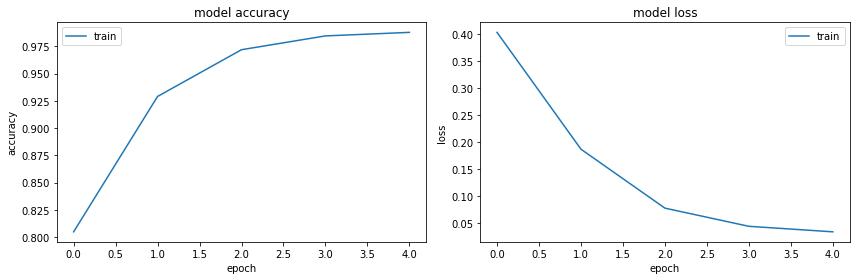

In [49]:
import matplotlib.pyplot as plt

def plot_training_curves(history): 
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    ax = axes[0]
    ax.plot(history['accuracy'], label='train')
    ax.set(title='model accuracy', ylabel='accuracy', xlabel='epoch')
    ax.legend()
    ax = axes[1]
    ax.plot(history['loss'], label='train')
    ax.set(title='model loss', ylabel='loss', xlabel='epoch')
    ax.legend()
    fig.tight_layout()
    
plot_training_curves(history)

# Batch Prediction


If our use case requires individual predictions in near real-time, SageMaker hosted endpoints can be created. Hosted endpoints also can be used for pseudo-batch prediction, but the process is more involved than simply using SageMaker's Batch Transform feature, which is designed for large-scale, asynchronous batch inference.

To use Batch Transform, we first upload to S3 some input test data to be transformed.  The data can be in any format accepted by your model; in this case, it is CSV.

In [51]:
csvtestdata_s3_prefix = '{}/data/csv-test'.format(s3_prefix)
csvtest_s3 = sagemaker.Session().upload_data(path='./data/csv-test/', bucket=bucket, key_prefix=csvtestdata_s3_prefix)
print(csvtest_s3)

s3://dgx-ds-use1-dev-landing-s3/kamal/tf-keras-sentiment/data/csv-test


A Transformer object must be set up to describe the Batch Transform job, including the amount and type of inference hardware to be used.  Then the actual transform job itself is started with a call to the `transform` method of the Transformer.  When setting up Batch Transform jobs, hardware considerations are important, just as they are for training:

- `instance_count`:  Batch Transform can spin up a cluster of multiple instances; at the end of the job, the cluster is torn down automatically.  Since this dataset is small, we'll just use one instance.
- `instance_type`:  When doing inference for smaller models, such as this one, often CPU-based instance types can be used instead of GPU instance types, allowing significant cost savings.  Note, however, that the choice of specific CPU instance type can significantly affect inference speed:  although we could use a general purpose instance here such as a m5.xlarge, if we use a compute-optimized c5.xlarge instance, the total batch inference time is cut in half.

In [54]:
transformer = estimator.transformer(instance_count=1,                                    
                                    #base_job_name='kamal-tf-sentiment-tfm',                                    
                                    instance_type='ml.c5.xlarge')

transformer.transform(csvtest_s3, content_type='text/csv')
print('Waiting for transform job: ' + transformer.latest_transform_job.job_name)
transformer.wait()

.......................INFO:__main__:starting services
INFO:tfs_utils:using default model name: model
INFO:tfs_utils:tensorflow serving model config: 
model_config_list: {
  config: {
    name: "model",
    base_path: "/opt/ml/model",
    model_platform: "tensorflow"
  }
}


INFO:__main__:using default model name: model
INFO:__main__:tensorflow serving model config: 
model_config_list: {
  config: {
    name: "model",
    base_path: "/opt/ml/model",
    model_platform: "tensorflow"
  }
}


INFO:__main__:starting services
INFO:tfs_utils:using default model name: model
INFO:tfs_utils:tensorflow serving model config: 
model_config_list: {
  config: {
    name: "model",
    base_path: "/opt/ml/model",
    model_platform: "tensorflow"
  }
}


INFO:__main__:using default model name: model
INFO:__main__:tensorflow serving model config: 
model_config_list: {
  config: {
    name: "model",
    base_path: "/opt/ml/model",
    model_platform: "tensorflow"
  }
}


INFO:__main__:tensorflow version 

We can now download the batch predictions from S3 to the local filesystem on the notebook instance; the predictions are contained in a file with a .out extension, and are embedded in JSON.  Next we'll load the JSON and examine the predictions, which are confidence scores from 0.0 to 1.0 where numbers close to 1.0 indicate positive sentiment, while numbers close to 0.0 indicate negative sentiment.

In [55]:
import json

batch_output = transformer.output_path
!mkdir -p batch_data/output
!aws s3 cp --recursive $batch_output/ batch_data/output/

with open('batch_data/output/csv-test.csv.out', 'r') as f:
    jstr = json.load(f)
    results = [float('%.3f'%(item)) for sublist in jstr['predictions'] for item in sublist]
    print(results)

download: s3://sagemaker-us-east-1-993818375429/kamal-tf-sentiment-2021-11-02-16-47-13--2021-11-02-16-47-13-503/csv-test.csv.out to batch_data/output/csv-test.csv.out
download: s3://sagemaker-us-east-1-993818375429/kamal-tf-sentiment-2021-11-02-16-47-13--2021-11-02-16-47-13-503/.ipynb_checkpoints/csv-test-checkpoint.csv.out to batch_data/output/.ipynb_checkpoints/csv-test-checkpoint.csv.out
[0.002, 0.997, 0.129, 0.98, 0.998, 0.998, 0.998, 0.002, 0.998, 1.0, 0.181, 0.007, 0.0, 0.994, 1.0, 0.0, 1.0, 0.999, 0.0, 0.001, 1.0, 1.0, 0.935, 1.0, 0.069, 1.0, 0.0, 1.0, 0.863, 0.0, 1.0, 0.672, 0.838, 0.0, 0.0, 0.0, 1.0, 1.0, 0.016, 0.0, 1.0, 0.996, 0.0, 0.968, 1.0, 0.999, 0.001, 0.0, 0.0, 0.98, 0.0, 0.008, 1.0, 0.999, 1.0, 0.01, 0.268, 0.999, 0.0, 0.0, 0.029, 0.0, 0.099, 0.0, 0.0, 1.0, 0.014, 0.983, 0.999, 1.0, 0.983, 1.0, 1.0, 0.0, 0.0, 0.917, 0.0, 1.0, 0.994, 0.005, 0.986, 0.963, 0.99, 0.999, 0.0, 0.0, 0.001, 0.415, 0.0, 0.993, 1.0, 0.999, 0.0, 0.993, 1.0, 0.0, 0.036, 1.0, 0.001, 0.0]


Now let's look at the text of some actual reviews to see the predictions in action.  First, we have to convert the integers representing the words back to the words themselves by using a reversed dictionary.  Next we can decode the reviews, taking into account that the first 3 indices were reserved for "padding", "start of sequence", and "unknown", and removing a string of unknown tokens from the start of the review.

In [56]:
import re

regex = re.compile(r'^[\?\s]+')

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
first_decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_test[0]])
regex.sub('', first_decoded_review)

1646592/1641221 [==============================] - 0s 0us/step


"please give this one a miss br br kristy swanson and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite lacklustre so all you madison fans give this a miss"

Overall, this review looks fairly negative.  Let's compare the actual label with the prediction:

In [57]:
def get_sentiment(score):
    return 'positive' if score > 0.5 else 'negative' 

print('Labeled sentiment for this review is {}, predicted sentiment is {}'.format(get_sentiment(y_test[0]), 
                                                                                  get_sentiment(results[0])))

Labeled sentiment for this review is negative, predicted sentiment is negative


Training deep learning models is a stochastic process, so your results may vary -- there is no guarantee that the predicted result will match the actual label. However, it is likely that the sentiment prediction agrees with the label for this review.  Let's now examine another review:

In [58]:
second_decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_test[5]])
regex.sub('', second_decoded_review)

"i'm absolutely disgusted this movie isn't being sold all who love this movie should email disney and increase the demand for it they'd eventually have to sell it then i'd buy copies for everybody i know everything and everybody in this movie did a good job and i haven't figured out why disney hasn't put this movie on dvd or on vhs in rental stores at least i haven't seen any copies this is a wicked good movie and should be seen by all the kids in the new generation don't get to see it and i think they should it should at least be put back on the channel this movie doesn't deserve a cheap download it deserves the real thing i'm them now this movie will be on dvd"

In [59]:
print('Labeled sentiment for this review is {}, predicted sentiment is {}'.format(get_sentiment(y_test[5]), 
                                                                                  get_sentiment(results[5])))

Labeled sentiment for this review is positive, predicted sentiment is positive


Again, it is likely (but not guaranteed) that the prediction agreed with the label for the test data.  Note that there is no need to clean up any Batch Transform resources:  after the transform job is complete, the cluster used to make inferences is torn down.  Now that we've reviewed some sample predictions as a sanity check, this brief example is complete.   